In [1]:
import numpy as np
import scipy
from scipy import sparse
from scipy.sparse.linalg import spsolve
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import argrelextrema
from sklearn.mixture import GaussianMixture
from scipy.optimize import curve_fit
from pybaselines import Baseline
from pybaselines.utils import gaussian
from lmfit import Parameters, Minimizer
from lmfit.models import LorentzianModel,ConstantModel, GaussianModel
from sklearn.metrics import auc

In [2]:
# Uploading the data of all lanes.

data = pd.read_csv("data/1_T19G+U19U_CY5_data_1.csv", comment='#',sep=',')

In [3]:
data

,Distance,Grey_Values_T0,Grey_Values_T10s,Grey_Values_T30s,Grey_Values_T1M,Grey_Values_T3M,Grey_Values_T6M,Grey_Values_T30M,Grey_Values_T100M,Grey_Values_Ladder1,Grey_Values_Ladder2
0,0.00,1393.611,1263.722,1244.389,1263.222,1215.889,1191.111,1241.556,1322.333,1372.944,1378.778
1,0.01,1381.333,1258.778,1243.556,1272.500,1211.333,1194.000,1246.111,1320.389,1369.444,1384.944
2,0.02,1399.222,1285.111,1239.333,1266.500,1222.944,1195.000,1260.778,1351.278,1382.444,1396.278
3,0.03,1334.278,1302.056,1239.778,1264.222,1225.278,1195.556,1263.222,1351.889,1392.611,1396.389
4,0.04,1319.000,1290.111,1242.111,1264.389,1236.056,1191.333,1245.000,1327.000,1397.167,1411.278
...,...,...,...,...,...,...,...,...,...,...,...
912,9.12,1515.389,1588.556,1627.833,1589.222,1650.167,1459.444,1795.111,1550.111,2807.111,3747.722
913,9.13,1512.944,1578.500,1607.500,1585.444,1627.667,1445.333,1794.889,1556.778,2833.611,3779.278
914,9.14,1509.833,1564.944,1575.556,1569.333,1604.722,1442.333,1797.111,1564.944,2837.778,3822.167
915,9.15,1510.389,1567.056,1584.389,1553.944,1587.611,1443.333,1796.333,1584.667,2839.167,3865.333


In [4]:
# Normalizing distance

data.iloc[:, 0] = (data.iloc[:, 0] - data.iloc[:, 0].min()) / (data.iloc[:, 0].max() - data.iloc[:, 0].min())
data

,Distance,Grey_Values_T0,Grey_Values_T10s,Grey_Values_T30s,Grey_Values_T1M,Grey_Values_T3M,Grey_Values_T6M,Grey_Values_T30M,Grey_Values_T100M,Grey_Values_Ladder1,Grey_Values_Ladder2
0,0.000000,1393.611,1263.722,1244.389,1263.222,1215.889,1191.111,1241.556,1322.333,1372.944,1378.778
1,0.001092,1381.333,1258.778,1243.556,1272.500,1211.333,1194.000,1246.111,1320.389,1369.444,1384.944
2,0.002183,1399.222,1285.111,1239.333,1266.500,1222.944,1195.000,1260.778,1351.278,1382.444,1396.278
3,0.003275,1334.278,1302.056,1239.778,1264.222,1225.278,1195.556,1263.222,1351.889,1392.611,1396.389
4,0.004367,1319.000,1290.111,1242.111,1264.389,1236.056,1191.333,1245.000,1327.000,1397.167,1411.278
...,...,...,...,...,...,...,...,...,...,...,...
912,0.995633,1515.389,1588.556,1627.833,1589.222,1650.167,1459.444,1795.111,1550.111,2807.111,3747.722
913,0.996725,1512.944,1578.500,1607.500,1585.444,1627.667,1445.333,1794.889,1556.778,2833.611,3779.278
914,0.997817,1509.833,1564.944,1575.556,1569.333,1604.722,1442.333,1797.111,1564.944,2837.778,3822.167
915,0.998908,1510.389,1567.056,1584.389,1553.944,1587.611,1443.333,1796.333,1584.667,2839.167,3865.333


In [5]:
data_t0s = data[["Distance", "Grey_Values_T0"]]
data_t10s = data[["Distance", "Grey_Values_T10s"]]
data_t30s = data [["Distance", "Grey_Values_T30s"]]
data_t1m = data[["Distance", "Grey_Values_T1M"]]
data_t3m = data[["Distance", "Grey_Values_T3M"]]
data_t6m = data[["Distance", "Grey_Values_T6M"]]
data_t30m = data[["Distance", "Grey_Values_T30M"]]
data_t100m = data[["Distance", "Grey_Values_T100M"]]
data_ladder1 = data[["Distance", "Grey_Values_Ladder1"]]
data_ladder2 = data[["Distance", "Grey_Values_Ladder2"]]

In [6]:
data_list = [data_t0s, data_t10s, data_t30s, data_t1m, data_t3m, data_t6m, data_t30m, data_t100m, data_ladder1, data_ladder2]

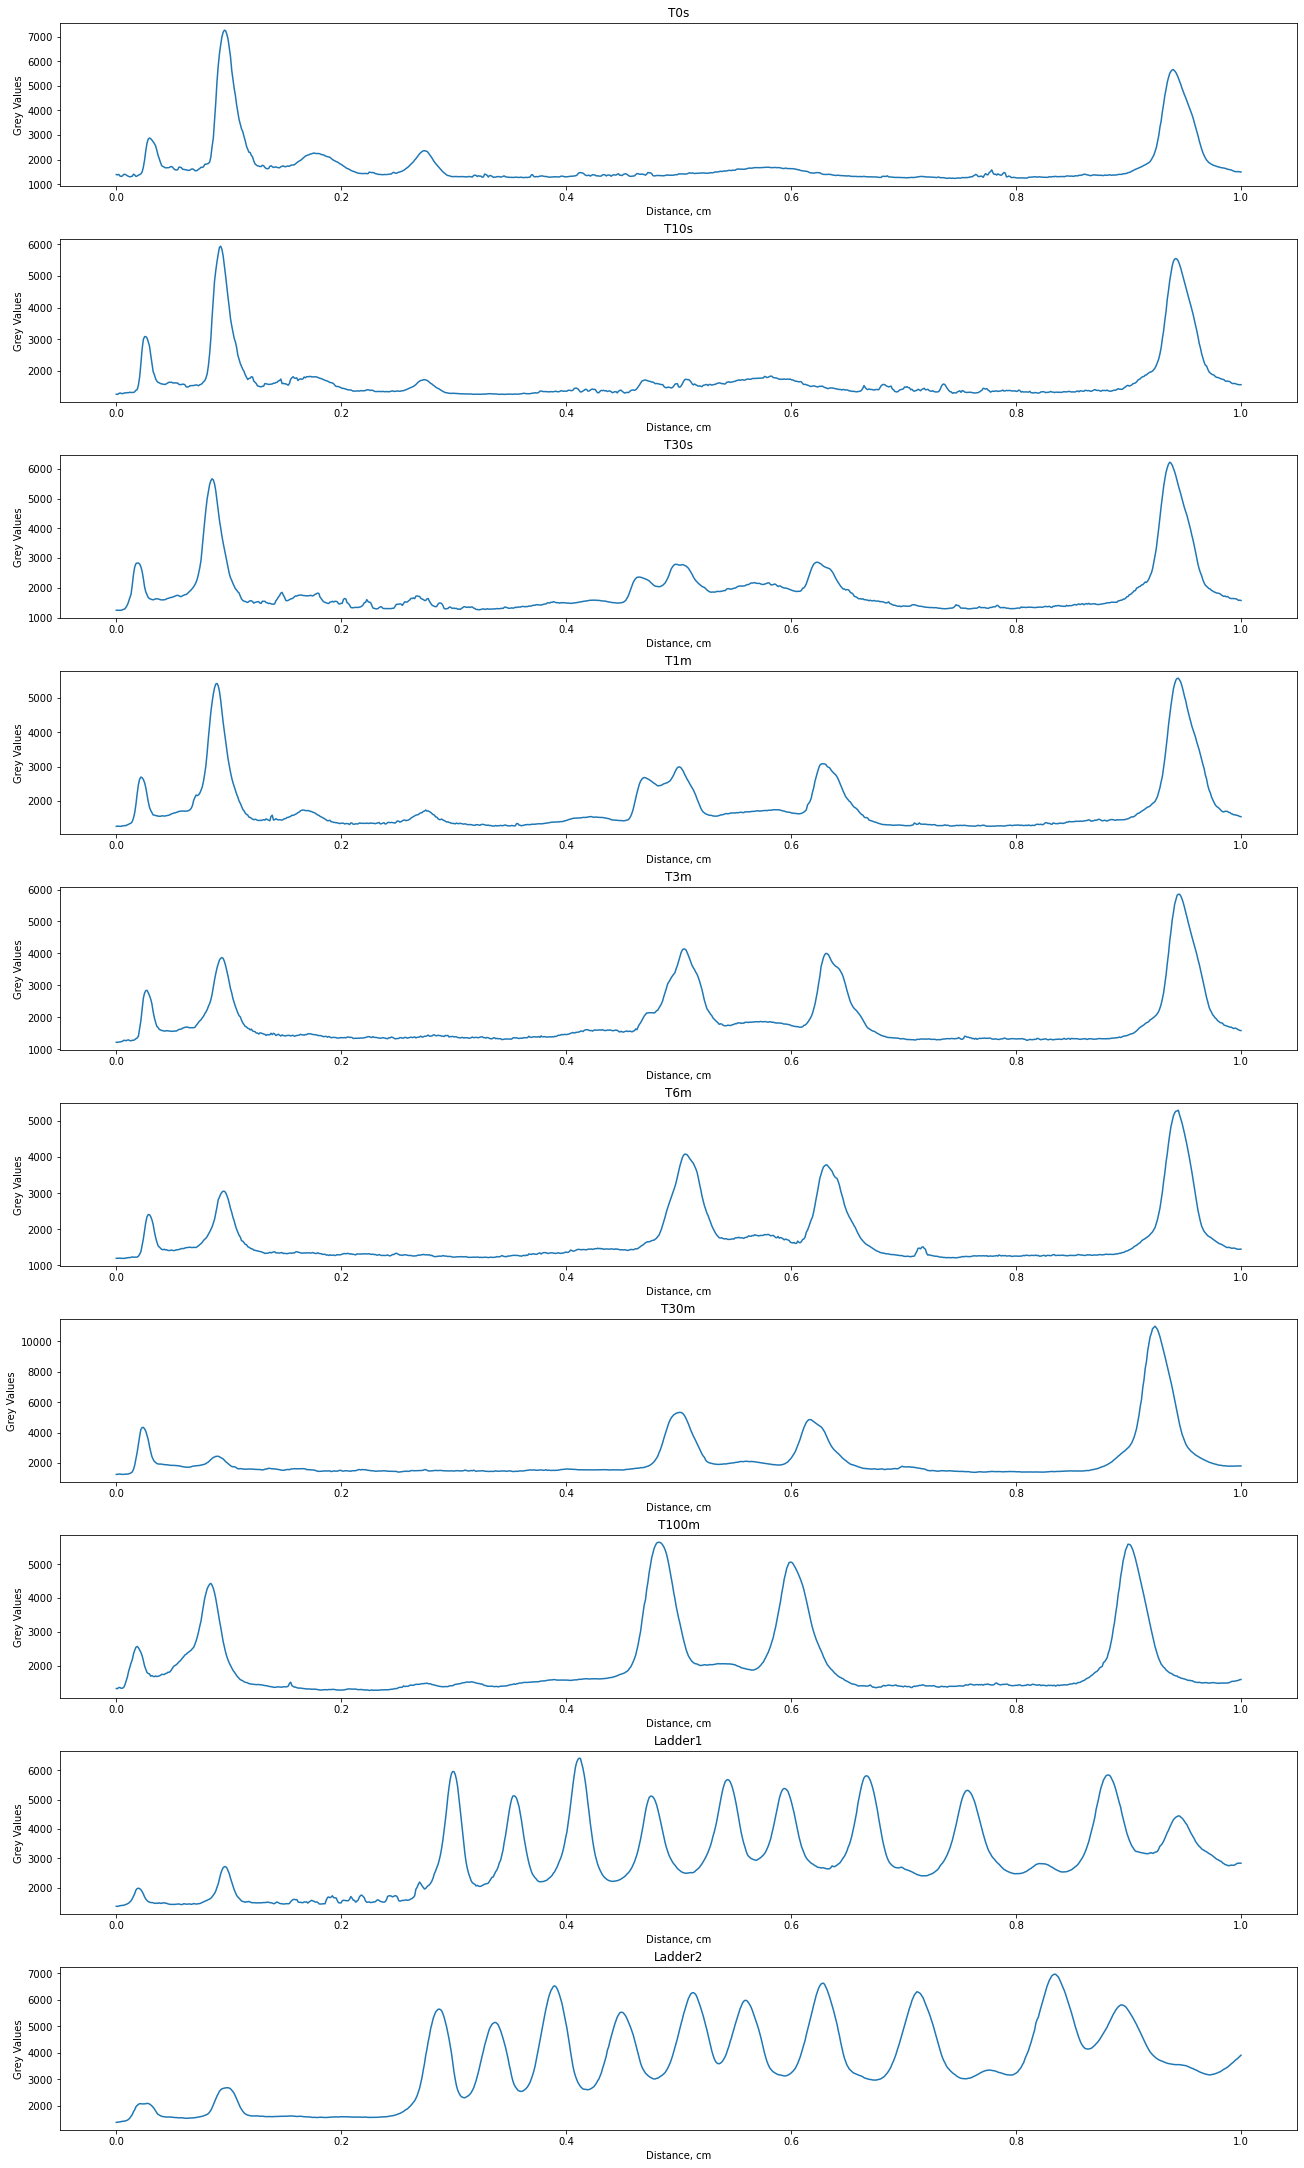

In [7]:
# Plotting the initial data with normalized distance

figure, axis = plt.subplots(nrows=10, figsize=(18, 30), constrained_layout=True)

for di, d in enumerate(data_list):
    name_list = ["T0s", "T10s", "T30s", "T1m", "T3m", "T6m", "T30m", "T100m", "Ladder1", "Ladder2"]
    axis[di].plot(d.iloc[:, 0], d.iloc[:, 1])
    axis[di].set_title(str(name_list[di])) 
    #axis[di].invert_xaxis()
    axis[di].set(xlabel="Distance, cm", ylabel="Grey Values")

In [8]:
# Adjusting the baseline for each case

data_adjust_list = []

for d in data_list:
    
    # Baseline removal
    baseline_fitter = Baseline(x_data=d.iloc[:, 0])
    imodpoly = baseline_fitter.imodpoly(d.iloc[:, 1], poly_order=3, num_std=0.8)
    new_y = d.iloc[:, 1]-imodpoly[0]
    
    data_nt = d.iloc[:, 0]
    data_grey = new_y.to_frame(name="Grey_Values")
    # Creating a new dataframe with new grey values
    df_new = pd.concat([data_nt, data_grey], axis=1)
    data_adjust_list.append(df_new)
    

In [9]:
# Converting negative values to 0

data_0_list = []

for d in data_adjust_list:
    d[d < 0] = 0
    data_0_list.append(d)

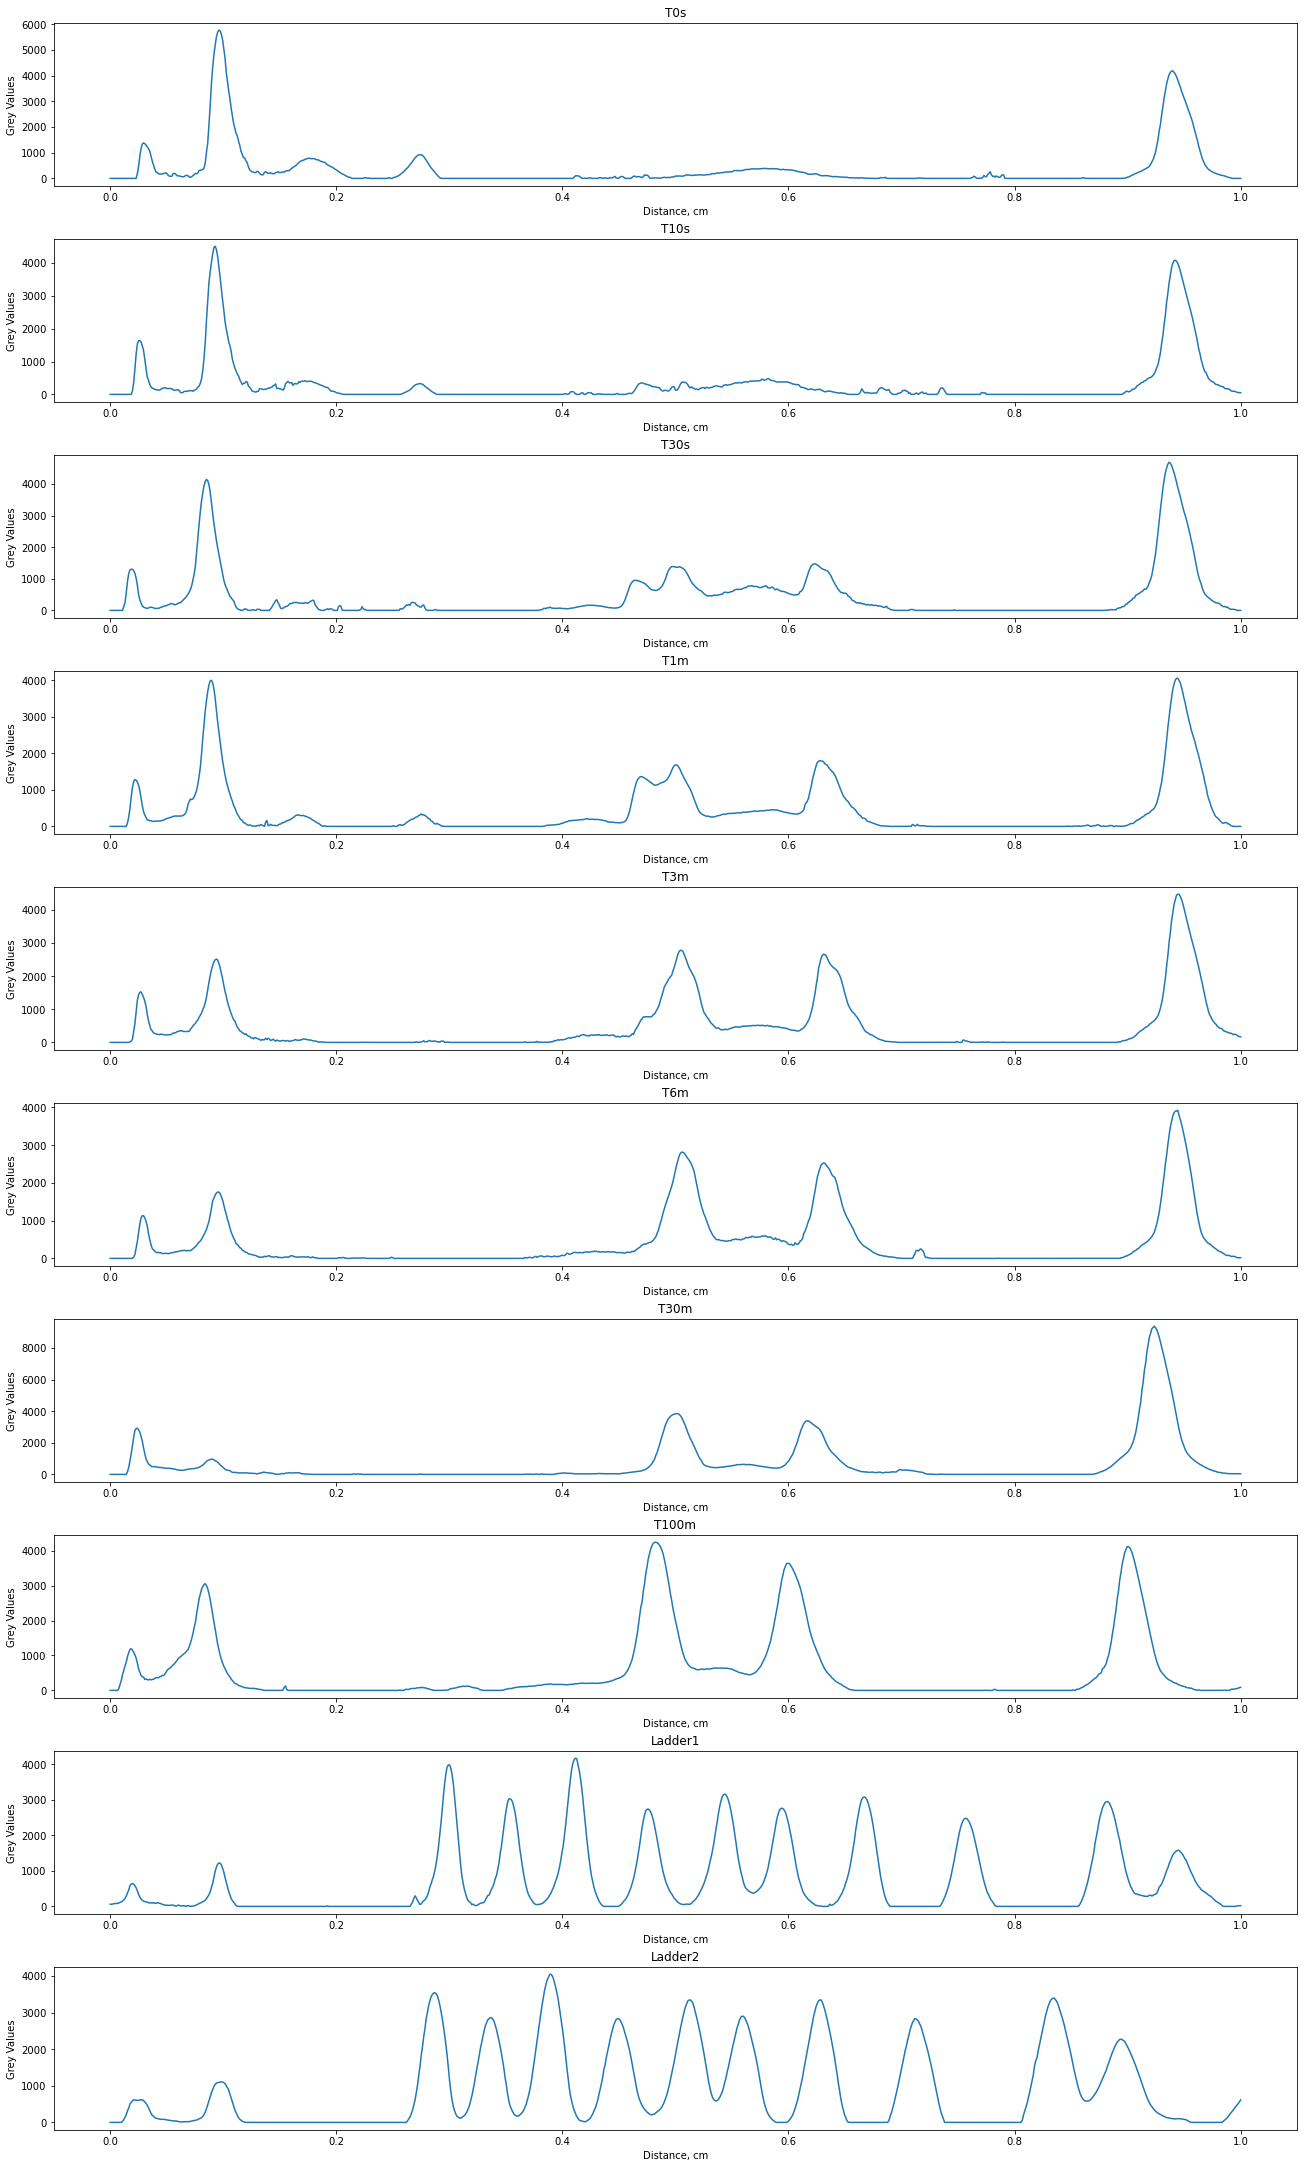

In [10]:
# Plotting the data with baseline adjusted

figure, axis = plt.subplots(nrows=10, figsize=(18, 30), constrained_layout=True)

for di, d in enumerate(data_0_list):
    name_list = ["T0s", "T10s", "T30s", "T1m", "T3m", "T6m", "T30m", "T100m", "Ladder1", "Ladder2"]
    axis[di].plot(d.iloc[:, 0], d.iloc[:, 1])
    axis[di].set_title(str(name_list[di])) 
    #axis[di].invert_xaxis()
    axis[di].set(xlabel="Distance, cm", ylabel="Grey Values")

In [13]:
# Cutting off the markers:

data_0_list_no_markers = []

for d in data_0_list:
    d = d[40:740]
    data_0_list_no_markers.append(d)

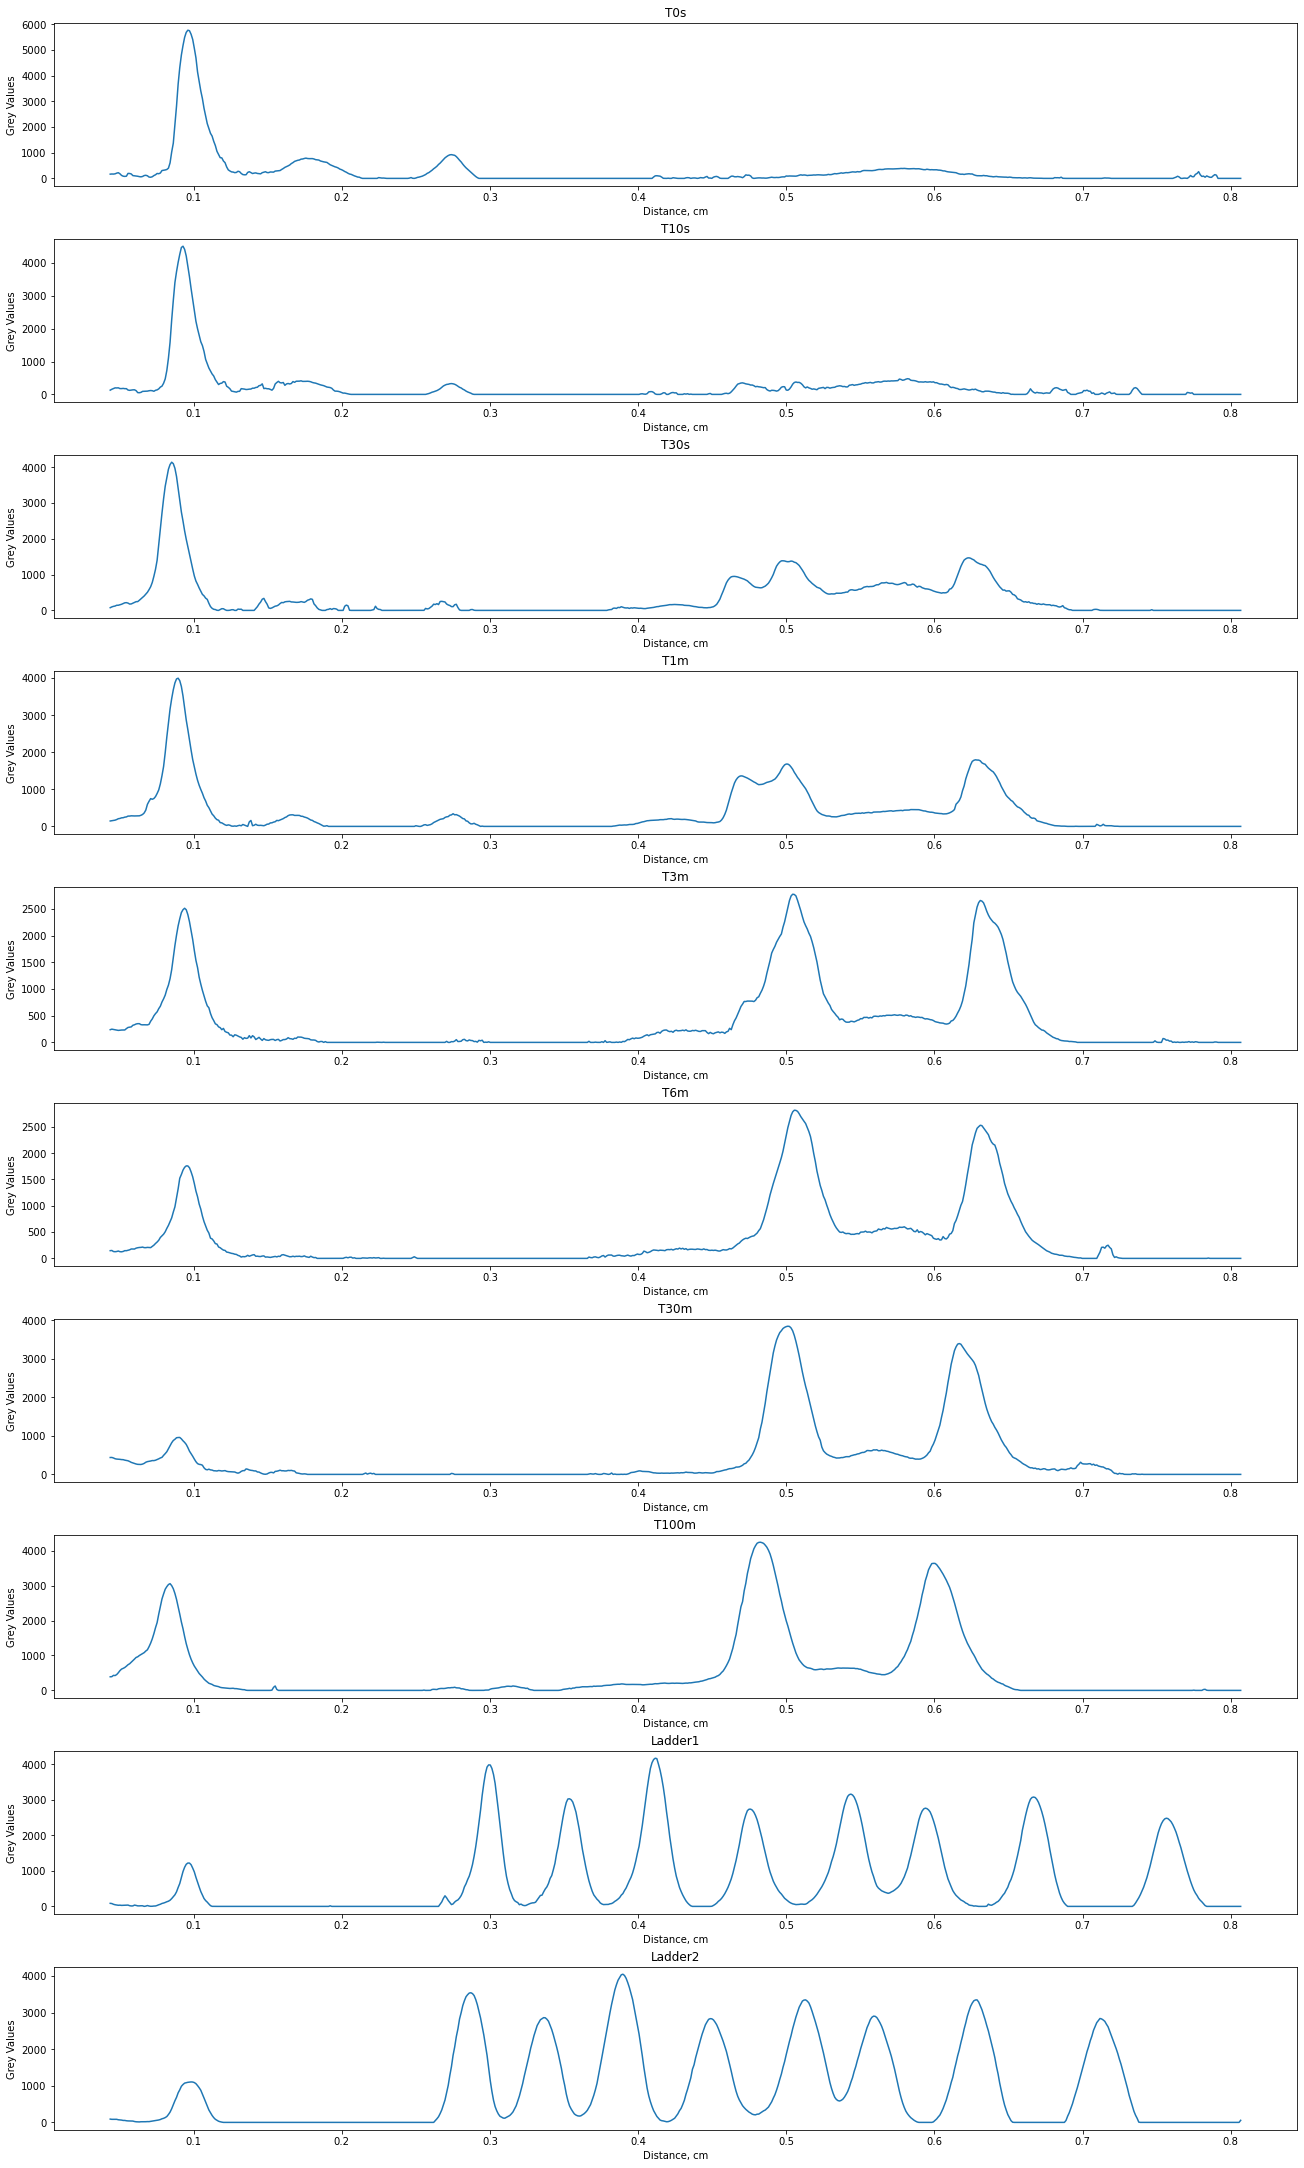

In [14]:
# Plotting the cut out peaks without markers

figure, axis = plt.subplots(nrows=10, figsize=(18, 30), constrained_layout=True)

for di, d in enumerate(data_0_list_no_markers):
    name_list = ["T0s", "T10s", "T30s", "T1m", "T3m", "T6m", "T30m", "T100m", "Ladder1", "Ladder2"]
    axis[di].plot(d.iloc[:, 0], d.iloc[:, 1])
    axis[di].set_title(str(name_list[di])) 
    #axis[di].invert_xaxis()
    axis[di].set(xlabel="Distance, cm", ylabel="Grey Values")

In [35]:
data_0_list_no_markers = data_0_list_no_markers[:-2]

In [49]:
# Selecting peak1 for the analysis

data_cutpeak_list1 = []

for d in data_0_list_no_markers:
    d = d[0:250]
    data_cutpeak_list1.append(d)

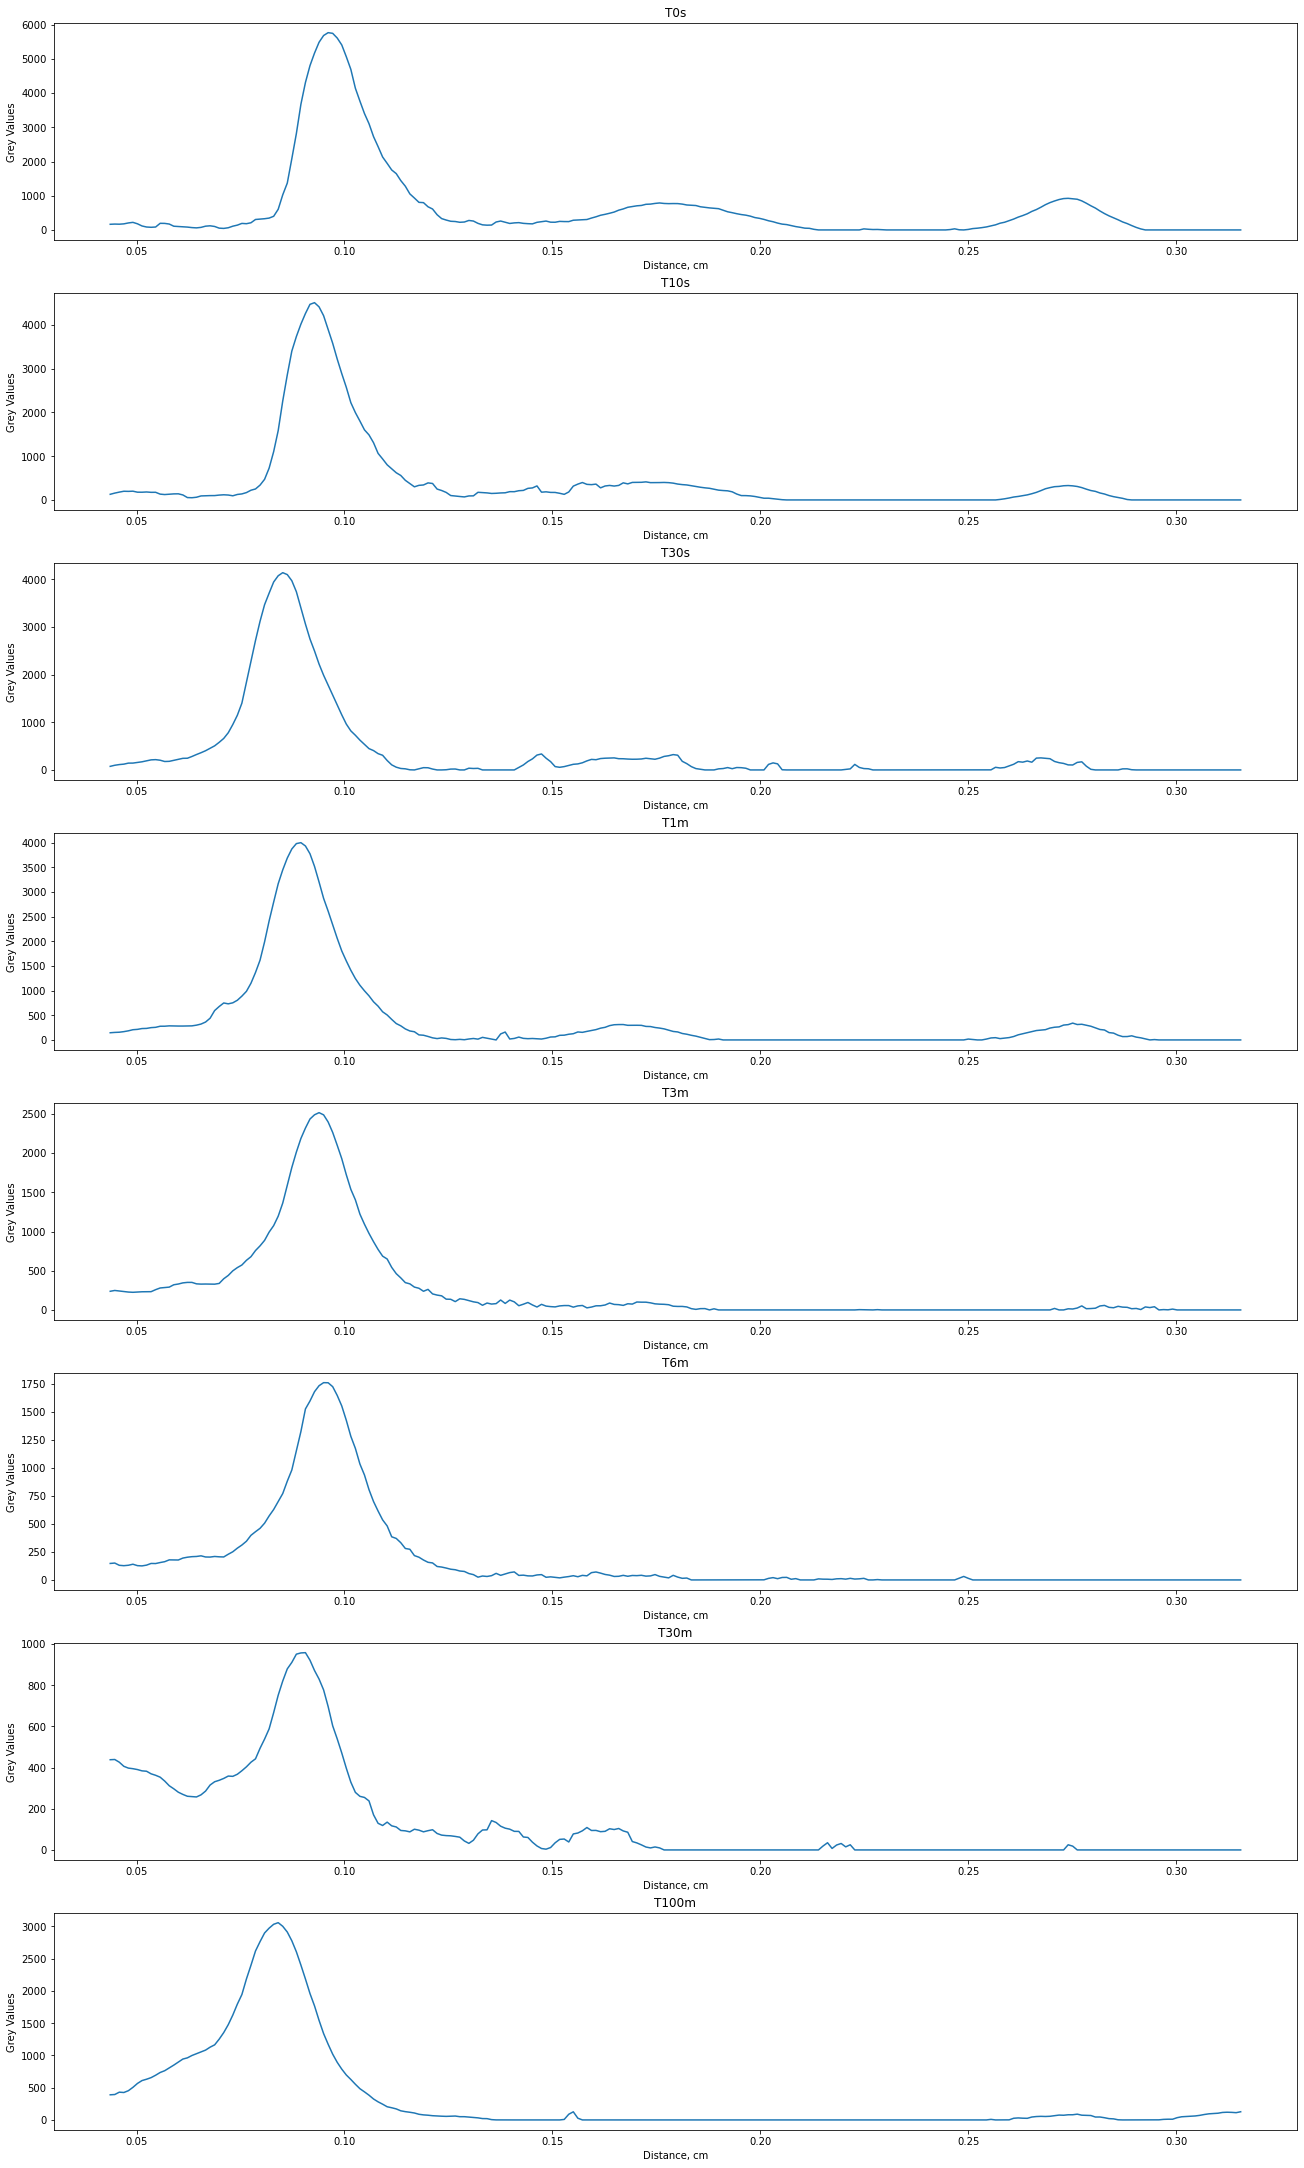

In [50]:
# Plotting the cut out peaks.

figure, axis = plt.subplots(nrows=8, figsize=(18, 30), constrained_layout=True)

for di, d in enumerate(data_cutpeak_list1):
    name_list = ["T0s", "T10s", "T30s", "T1m", "T3m", "T6m", "T30m", "T100m"]
    axis[di].plot(d.iloc[:, 0], d.iloc[:, 1])
    axis[di].set_title(str(name_list[di])) 
    #axis[di].invert_xaxis()
    axis[di].set(xlabel="Distance, cm", ylabel="Grey Values")

In [38]:
# Selecting peak2 for the analysis

data_cutpeak_list2 = []

for d in data_0_list_no_markers:
    d = d[350:460]
    data_cutpeak_list2.append(d)

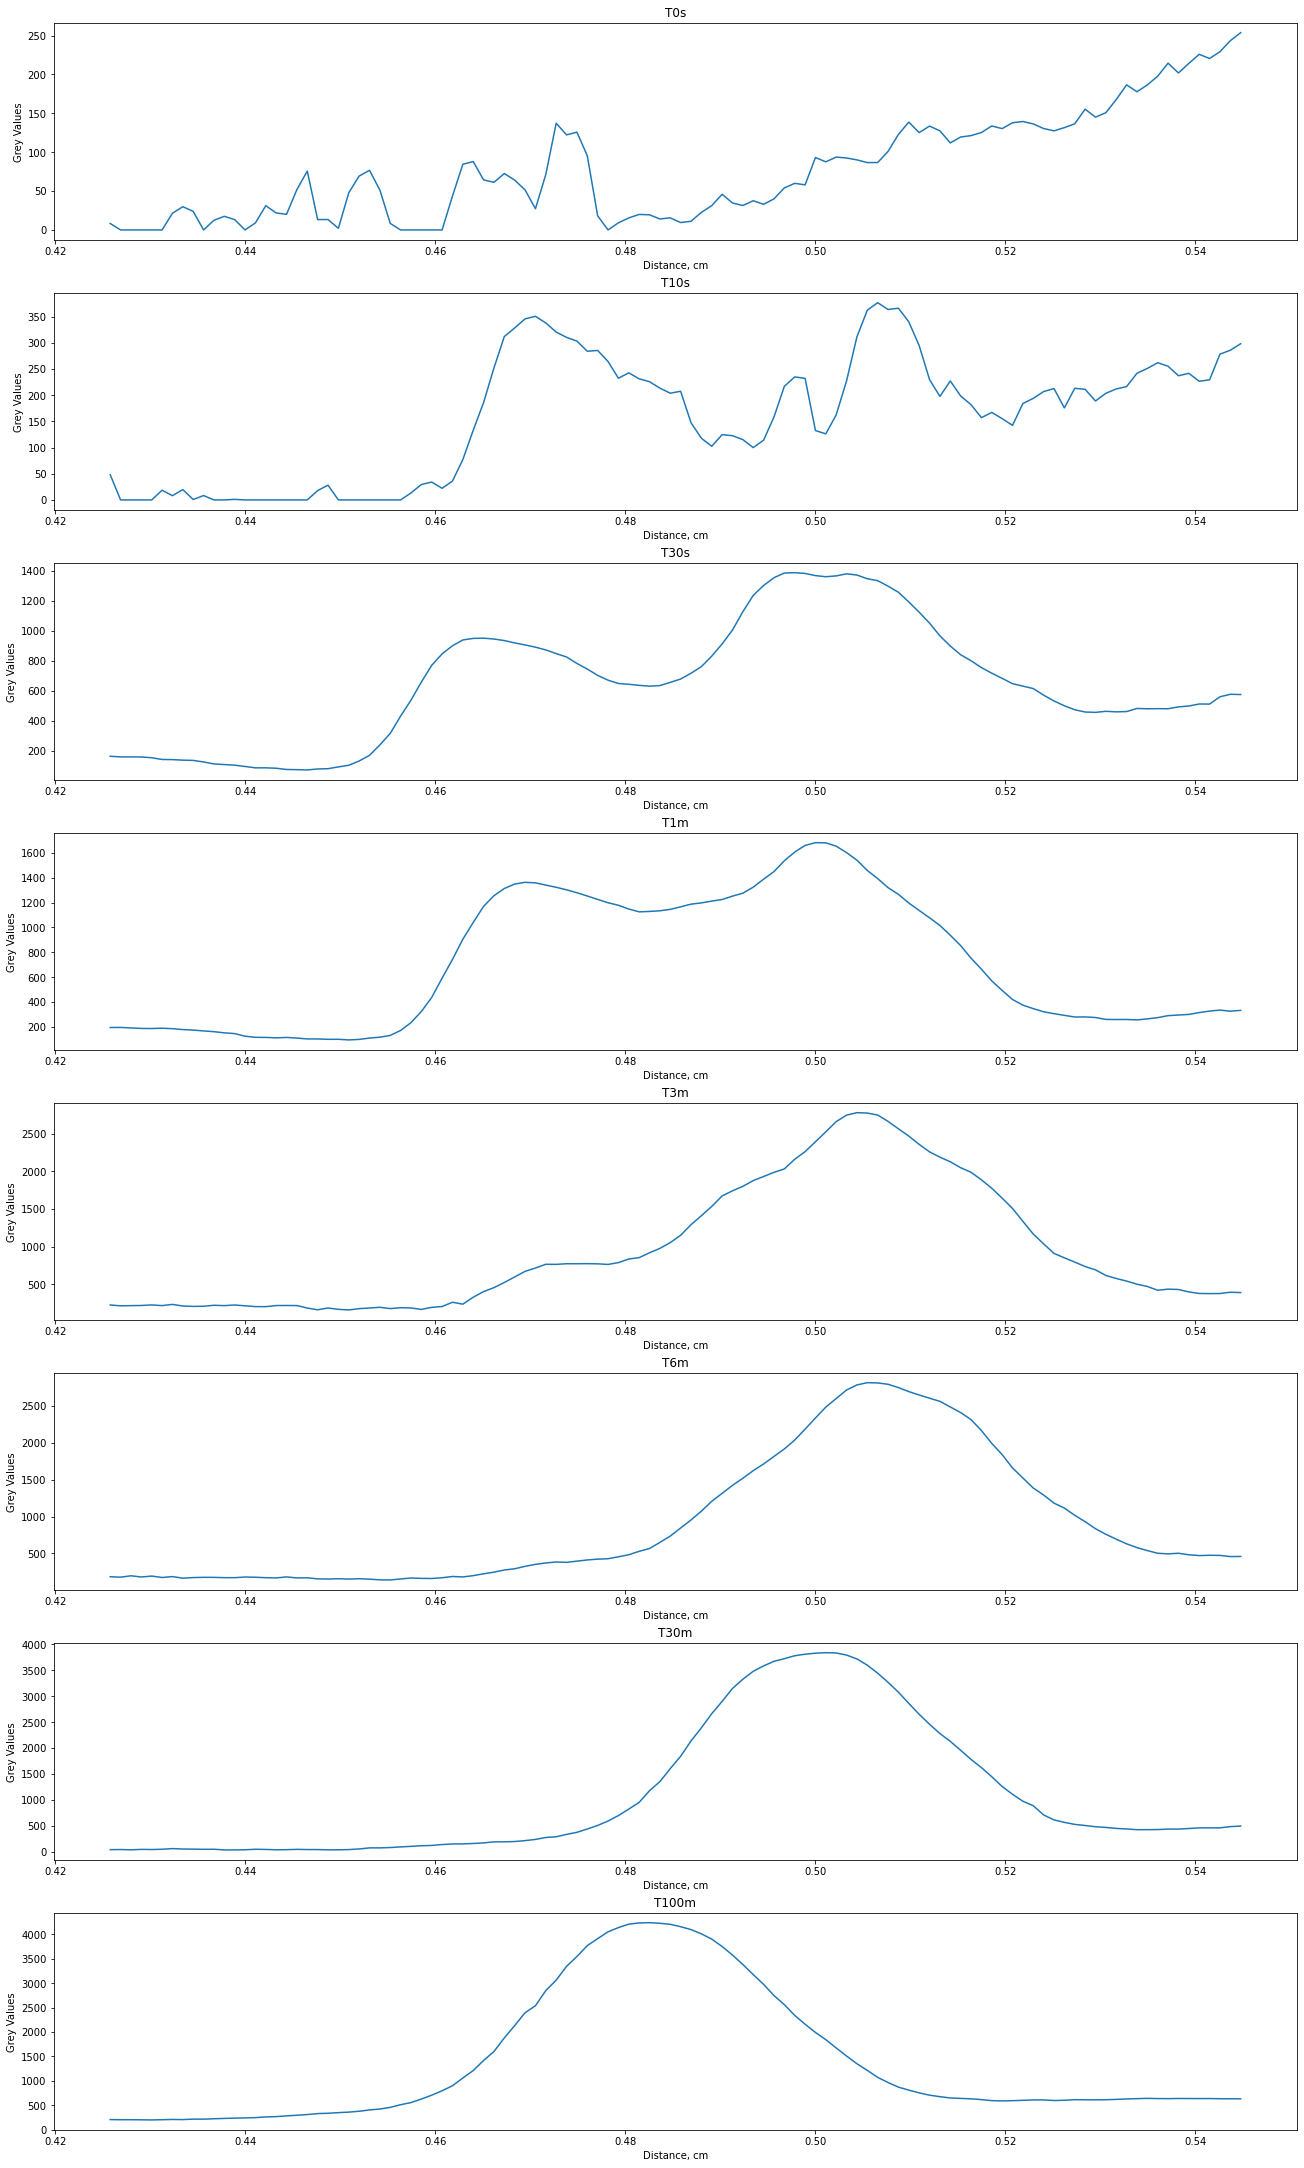

In [39]:
# Plotting the cut out peaks.

figure, axis = plt.subplots(nrows=8, figsize=(18, 30), constrained_layout=True)

for di, d in enumerate(data_cutpeak_list2):
    name_list = ["T0s", "T10s", "T30s", "T1m", "T3m", "T6m", "T30m", "T100m"]
    axis[di].plot(d.iloc[:, 0], d.iloc[:, 1])
    axis[di].set_title(str(name_list[di])) 
    #axis[di].invert_xaxis()
    axis[di].set(xlabel="Distance, cm", ylabel="Grey Values")

In [40]:
# Selecting peak3 for the analysis

data_cutpeak_list3 = []

for d in data_0_list_no_markers:
    d = d[460:610]
    data_cutpeak_list3.append(d)

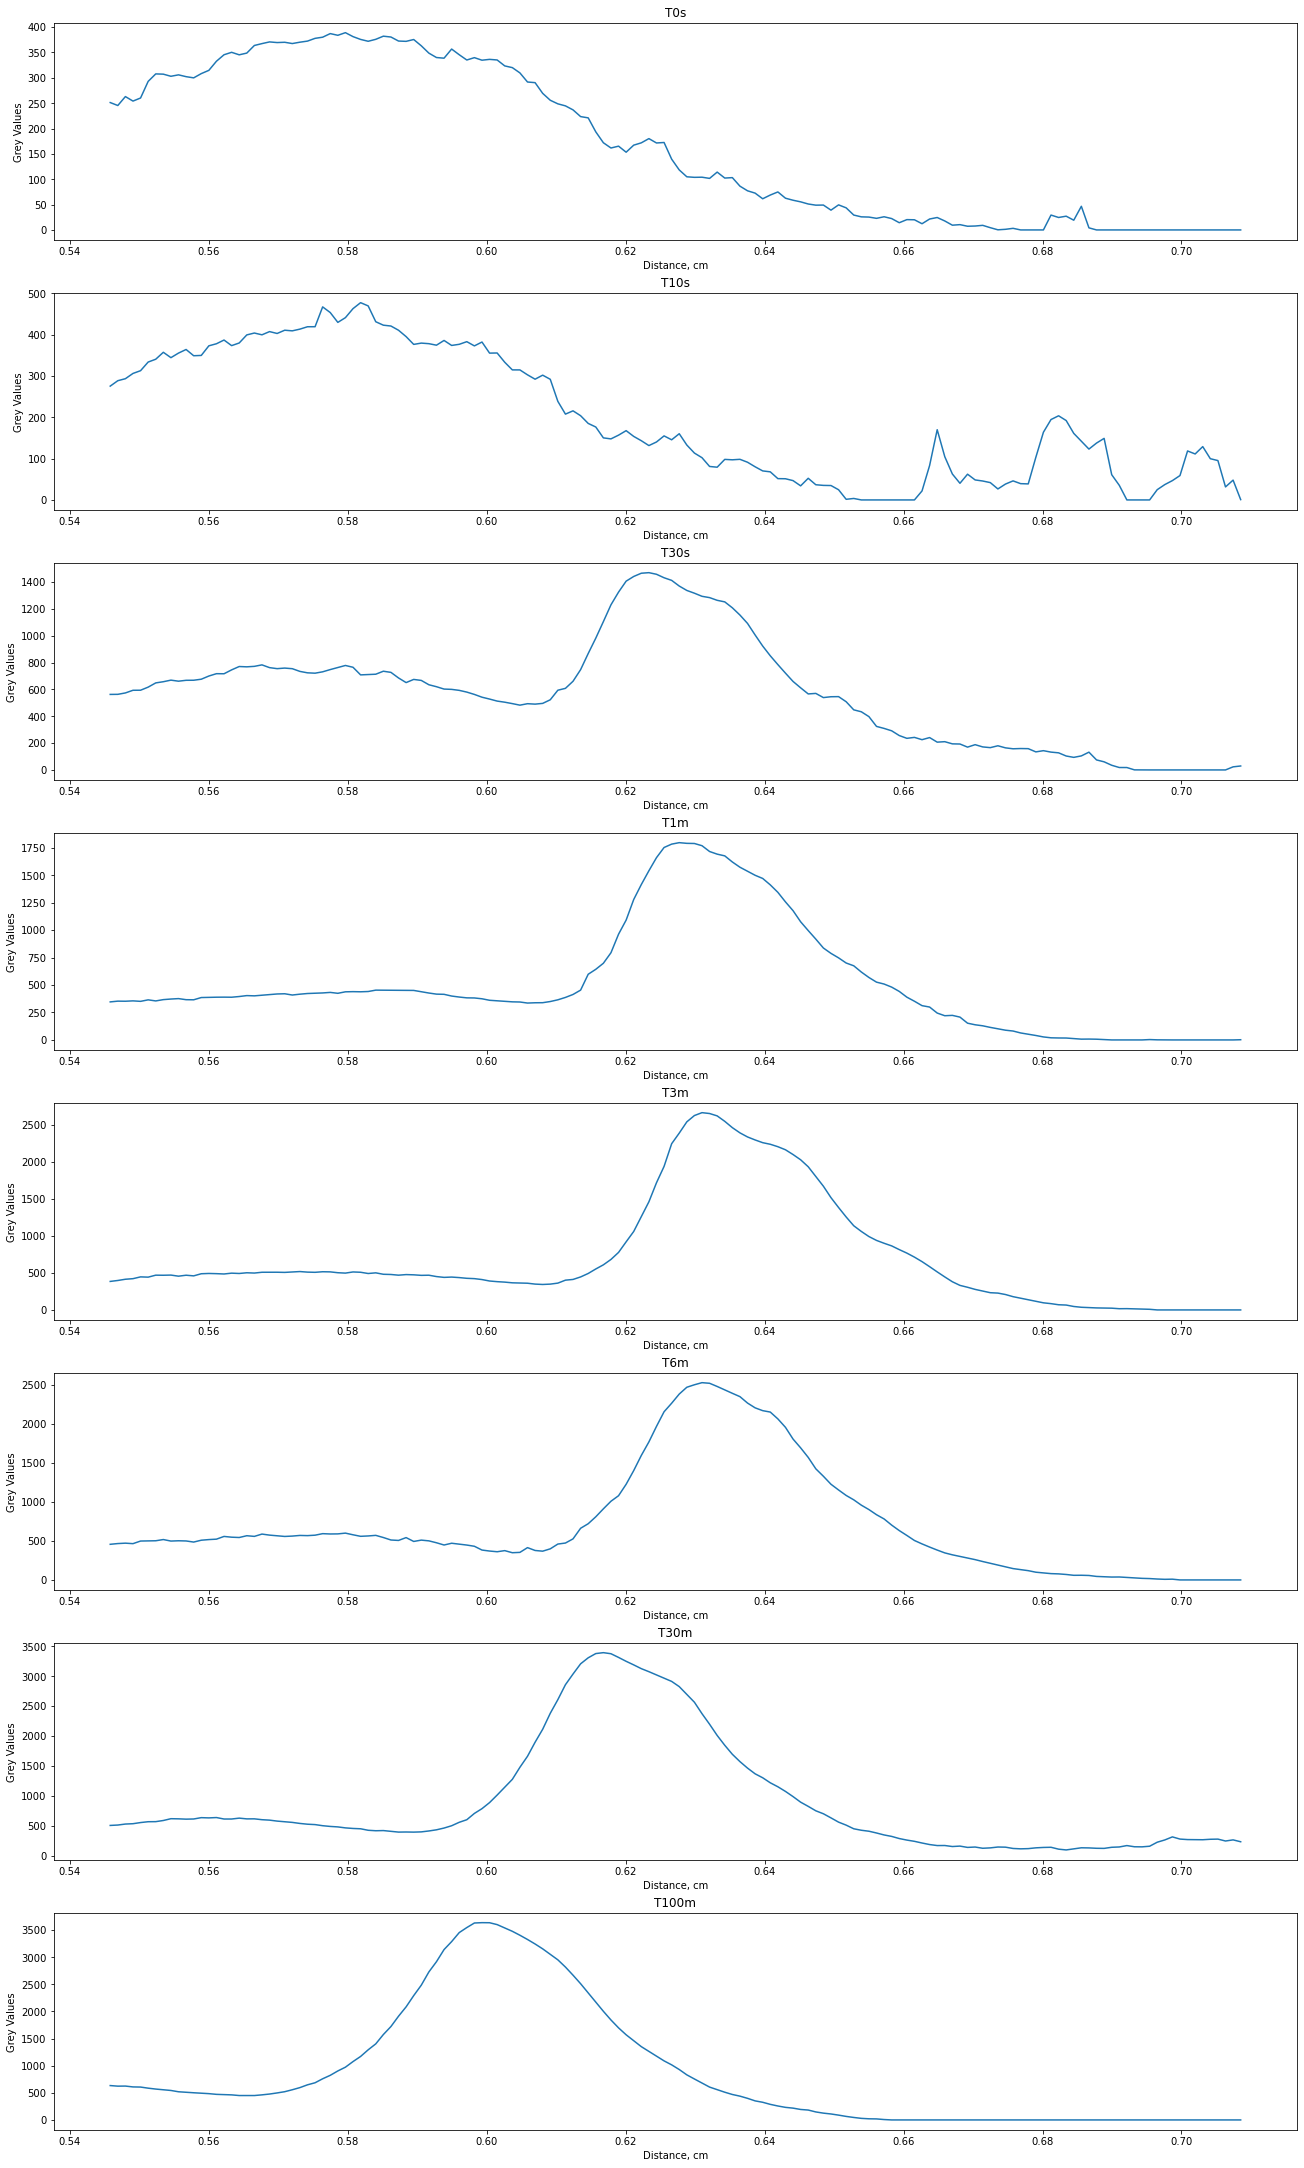

In [41]:
# Plotting the cut out peaks.

figure, axis = plt.subplots(nrows=8, figsize=(18, 30), constrained_layout=True)

for di, d in enumerate(data_cutpeak_list3):
    name_list = ["T0s", "T10s", "T30s", "T1m", "T3m", "T6m", "T30m", "T100m"]
    axis[di].plot(d.iloc[:, 0], d.iloc[:, 1])
    axis[di].set_title(str(name_list[di])) 
    #axis[di].invert_xaxis()
    axis[di].set(xlabel="Distance, cm", ylabel="Grey Values")

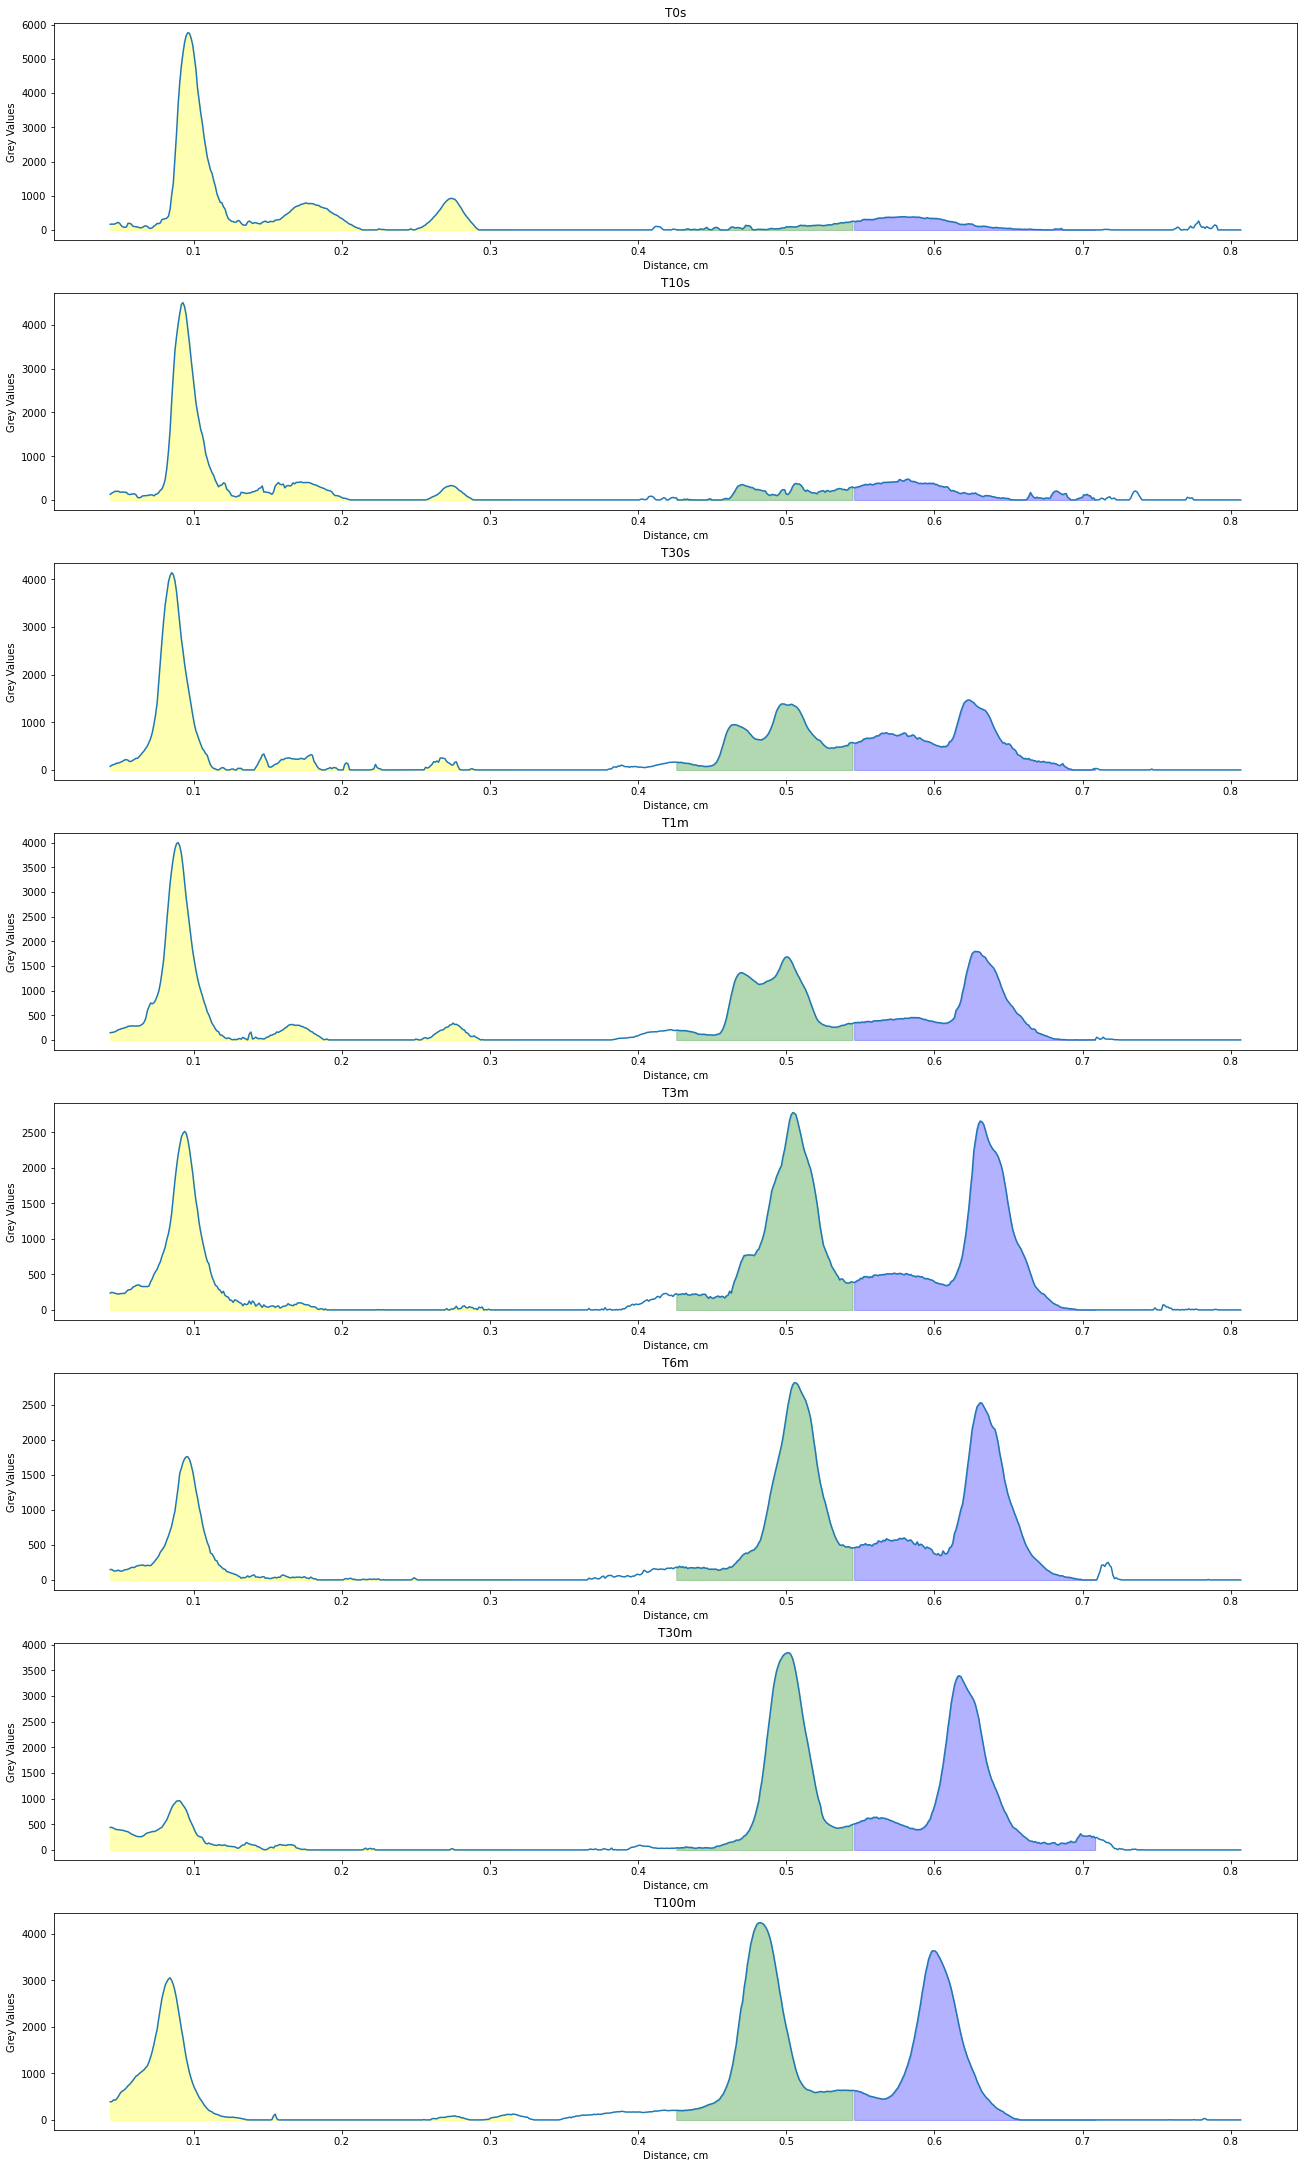

In [48]:
# Plotting the cut out peaks without markers

figure, axis = plt.subplots(nrows=8, figsize=(18, 30), constrained_layout=True)

for di, d in enumerate(data_0_list_no_markers):
    name_list = ["T0s", "T10s", "T30s", "T1m", "T3m", "T6m", "T30m", "T100m"]
    axis[di].plot(d.iloc[:, 0], d.iloc[:, 1])
    dx1 = d[0:250]
    axis[di].fill_between(dx1.iloc[:, 0], dx1.iloc[:, 1], color='yellow', alpha=0.3)
    dx2 = d[350:460]
    axis[di].fill_between(dx2.iloc[:, 0], dx2.iloc[:, 1], color='green', alpha=0.3)
    dx3 = d[460:610]
    axis[di].fill_between(dx3.iloc[:, 0], dx3.iloc[:, 1], color='blue', alpha=0.3)
    axis[di].set_title(str(name_list[di])) 
    #axis[di].invert_xaxis()
    axis[di].set(xlabel="Distance, cm", ylabel="Grey Values")

In [51]:
# Getting total area under the curve of each lane

auc_list_total = []

for d in data_0_list_no_markers:
    d_auc1 = auc(d.iloc[0:250,0], d.iloc[0:250,1])
    d_auc2 = auc(d.iloc[350:460,0], d.iloc[350:460,1])
    d_auc3 = auc(d.iloc[460:610,0], d.iloc[460:610,1])
    d_auc = d_auc1+d_auc2+d_auc3 
    auc_list_total.append(d_auc)
    

In [52]:
auc_list_total

[211.04362531056415,
 164.36419542603147,
 270.5473037021436,
 275.48020086814404,
 301.35447284450504,
 272.6645915006011,
 311.6793220127811,
 400.6007789192118]

In [53]:
# Getting the total area under the curve of substrate in each lane

auc_substrate_list = []

for d in data_cutpeak_list1:
    d_auc = auc(d.iloc[:, 0], d.iloc[:, 1])
    auc_substrate_list.append(d_auc)

In [56]:
# Getting the percentage of substrate in each lane

auc_percent_substrate = [float(i) / float(j) for i,j in zip(auc_substrate_list, auc_list_total)]

auc_percent_substrate

[0.8273953968781973,
 0.6876302352547125,
 0.3702079770223318,
 0.3824692542711333,
 0.23855467651251486,
 0.17571718200349062,
 0.11367554634250887,
 0.2298471478302527]

In [86]:
auc_percent_substrate[0] = 1
auc_percent_substrate[-1] = 0
time_points = [0, 10, 30, 60, 180, 360, 1800, 6000]
time = pd.DataFrame(time_points, columns=["Time_Points"])
auc_sub = pd.DataFrame(auc_percent_substrate, columns=["Percentage"])
df_sub = pd.concat([time, auc_sub], axis=1)
df_sub

,Time_Points,Percentage
0,0,1.000000
1,10,0.687630
2,30,0.370208
3,60,0.382469
4,180,0.238555
5,360,0.175717
6,1800,0.113676
7,6000,0.000000


In [87]:
df_sub.to_csv('data/1_T19G+U19U_CY5_substrate_decay.csv', encoding='utf-8', index = False, header = False)

In [84]:
# Getting the total area under the curve of peak2 in each lane

auc_peak2_list = []

for d in data_cutpeak_list2:
    d_auc = auc(d.iloc[:, 0], d.iloc[:, 1])
    auc_peak2_list.append(d_auc)

In [85]:
# Getting the percentage of peak2 in each lane

auc_percent2 = [float(i) / float(j) for i,j in zip(auc_peak2_list, auc_list_total)]

auc_percent2

[0.04348514536381535,
 0.11485209934607468,
 0.2871480846204571,
 0.31122667505834034,
 0.3779132203138869,
 0.3986437097788279,
 0.4157148885342007,
 0.4137265339443984]

In [89]:
time_points = [0, 10, 30, 60, 180, 360, 1800, 6000]
time = pd.DataFrame(time_points, columns=["Time_Points"])
auc_pr1 = pd.DataFrame(auc_percent2, columns=["Percentage"])
df_pr1= pd.concat([time, auc_pr1], axis=1)
df_pr1

,Time_Points,Percentage
0,0,0.043485
1,10,0.114852
2,30,0.287148
3,60,0.311227
4,180,0.377913
5,360,0.398644
6,1800,0.415715
7,6000,0.413727


In [92]:
df_pr1.to_csv('data/1_T19G+U19U_CY5_product_1.csv', encoding='utf-8', index = False, header = False)

In [90]:
# Getting the total area under the curve of peak3 in each lane

auc_peak3_list = []

for d in data_cutpeak_list3:
    d_auc = auc(d.iloc[:, 0], d.iloc[:, 1])
    auc_peak3_list.append(d_auc)

In [91]:
# Getting the percentage of peak2 in each lane

auc_percent3 = [float(i) / float(j) for i,j in zip(auc_peak3_list, auc_list_total)]

auc_percent3

[0.12911945775798725,
 0.19751766539921284,
 0.3426439383572111,
 0.30630407067052634,
 0.38353210317359815,
 0.4256391082176815,
 0.4706095651232905,
 0.3564263182253489]

In [93]:
time_points = [0, 10, 30, 60, 180, 360, 1800, 6000]
time = pd.DataFrame(time_points, columns=["Time_Points"])
auc_pr2 = pd.DataFrame(auc_percent3, columns=["Percentage"])
df_pr2= pd.concat([time, auc_pr2], axis=1)
df_pr2

,Time_Points,Percentage
0,0,0.129119
1,10,0.197518
2,30,0.342644
3,60,0.306304
4,180,0.383532
5,360,0.425639
6,1800,0.470610
7,6000,0.356426


In [94]:
df_pr2.to_csv('data/1_T19G+U19U_CY5_product_2.csv', encoding='utf-8', index = False, header = False)